# Home Credit Default Risk Modelling


## Story behind the wheel! (Introduction)

This title make me realize the scrutiny behind the Risk. 
Any organisation that gives Credit to a customer, whether that customer is a typical consumer, business or government organisation, should be able to understand their risk (and potential exposure) should the client default on the loan. I am no expert in the field of Risk modelling, but I am aware that this is typical process in many financial services companies. This means that Credit Risk modelling is important and is worth learning more about.

## Imports

In [1]:
# All Package Imports
import pandas as pd
import numpy as np
import os
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import time



In [2]:
!pip install lightgbm
import lightgbm as lgb

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


In [4]:
# import sklearn packages for modelling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline



First and foremost, we need to understand the data which we have for this model. There are multiple datasets, but we will need to focus on the application train (and application test) datasets first and then use the other data to enrich the train and test with more features to improve the model. 

So the first objective in this notebook will be to:
* Exploratory Data Analysis
* Data Transformation (Encoding)
* Data Transformation (Scaling/Normalisation)
* Benchmark Models Cross-validation

Then I can go on to explore (time permitting):
* Feature engineering using existing dataset
* Feature engineering using additional data

But without further ado, lets start by exploring the data to understand intuitively what is contained within it.

## Data Load

In [5]:
# load and print head of the a_train dataset
train_data = pd.read_csv('Input/application_train.csv')
train_data.head()

# keep original version of a_train for exploratory visualisations
raw_train = train_data.copy(deep = True)

In [6]:
# Train matrix shape
train_data.shape

(307511, 122)

In [7]:
print(train_data.columns.values)

['SK_ID_CURR' 'TARGET' 'NAME_CONTRACT_TYPE' 'CODE_GENDER' 'FLAG_OWN_CAR'
 'FLAG_OWN_REALTY' 'CNT_CHILDREN' 'AMT_INCOME_TOTAL' 'AMT_CREDIT'
 'AMT_ANNUITY' 'AMT_GOODS_PRICE' 'NAME_TYPE_SUITE' 'NAME_INCOME_TYPE'
 'NAME_EDUCATION_TYPE' 'NAME_FAMILY_STATUS' 'NAME_HOUSING_TYPE'
 'REGION_POPULATION_RELATIVE' 'DAYS_BIRTH' 'DAYS_EMPLOYED'
 'DAYS_REGISTRATION' 'DAYS_ID_PUBLISH' 'OWN_CAR_AGE' 'FLAG_MOBIL'
 'FLAG_EMP_PHONE' 'FLAG_WORK_PHONE' 'FLAG_CONT_MOBILE' 'FLAG_PHONE'
 'FLAG_EMAIL' 'OCCUPATION_TYPE' 'CNT_FAM_MEMBERS' 'REGION_RATING_CLIENT'
 'REGION_RATING_CLIENT_W_CITY' 'WEEKDAY_APPR_PROCESS_START'
 'HOUR_APPR_PROCESS_START' 'REG_REGION_NOT_LIVE_REGION'
 'REG_REGION_NOT_WORK_REGION' 'LIVE_REGION_NOT_WORK_REGION'
 'REG_CITY_NOT_LIVE_CITY' 'REG_CITY_NOT_WORK_CITY'
 'LIVE_CITY_NOT_WORK_CITY' 'ORGANIZATION_TYPE' 'EXT_SOURCE_1'
 'EXT_SOURCE_2' 'EXT_SOURCE_3' 'APARTMENTS_AVG' 'BASEMENTAREA_AVG'
 'YEARS_BEGINEXPLUATATION_AVG' 'YEARS_BUILD_AVG' 'COMMONAREA_AVG'
 'ELEVATORS_AVG' 'ENTRANCES_AVG' 'FLOOR

In [8]:
train_data.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
CNT_CHILDREN                    int64
AMT_INCOME_TOTAL              float64
AMT_CREDIT                    float64
AMT_ANNUITY                   float64
AMT_GOODS_PRICE               float64
NAME_TYPE_SUITE                object
NAME_INCOME_TYPE               object
NAME_EDUCATION_TYPE            object
NAME_FAMILY_STATUS             object
NAME_HOUSING_TYPE              object
REGION_POPULATION_RELATIVE    float64
DAYS_BIRTH                      int64
DAYS_EMPLOYED                   int64
DAYS_REGISTRATION             float64
DAYS_ID_PUBLISH                 int64
OWN_CAR_AGE                   float64
FLAG_MOBIL                      int64
FLAG_EMP_PHONE                  int64
FLAG_WORK_PHONE                 int64
FLAG_CONT_MOBILE                int64
FLAG_PHONE  

In [9]:
# load and print head of the a_train dataset
test_data = pd.read_csv('Input/application_test.csv')
test_data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Test matrix shape
test_data.shape

(48744, 121)

In [11]:
train_data .DAYS_BIRTH

0         -9461
1        -16765
2        -19046
3        -19005
4        -19932
5        -16941
6        -13778
7        -18850
8        -20099
9        -14469
10       -10197
11       -20417
12       -13439
13       -14086
14       -14583
15        -8728
16       -12931
17        -9776
18       -17718
19       -11348
20       -18252
21       -14815
22       -11146
23       -24827
24       -11286
25       -19334
26       -18724
27       -15948
28        -9994
29       -10341
          ...  
307481   -20644
307482   -14106
307483   -24911
307484   -12847
307485   -11973
307486   -16010
307487   -23125
307488   -10092
307489   -16471
307490    -9874
307491   -10976
307492   -20965
307493   -17533
307494   -14958
307495   -20922
307496   -17345
307497   -16679
307498   -19102
307499   -16988
307500   -20390
307501   -12961
307502   -16063
307503   -11870
307504   -16705
307505   -24384
307506    -9327
307507   -20775
307508   -14966
307509   -11961
307510   -16856
Name: DAYS_BIRTH, Length

In [12]:
def convertAge(age):
    age = int((age - (age * 2))/365)
    return age
# df['DAYS_BIRTH'] = df['DAYS_BIRTH'].apply(convertAge

In [13]:
train_data['AGE'] = train_data["DAYS_BIRTH"].apply(convertAge)

In [14]:
del train_data["DAYS_BIRTH"]

In [15]:
train_data.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,25
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,45


In [16]:
train_data.describe

<bound method NDFrame.describe of         SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
5           100008       0         Cash loans           M            N   
6           100009       0         Cash loans           F            Y   
7           100010       0         Cash loans           M            Y   
8           100011       0         Cash loans           F            N   
9           100012       0    Revolving loans           M            N   
10          100014       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
12  

So there are 121 features in the train and test data, with the train data having an additional target column. We can see that the test set is approximately a sixth of the size of the training set.

## Exploratory Data Analysis

EDA is useful for us to be able to understand what sort of data we are working with and build up some intuition about trends within the data. 


In [17]:
cat_cols = [
    "AMT_INCOME_TOTAL",
    "CODE_GENDER",
    "NAME_INCOME_TYPE",
    "AGE"
]

In [18]:
num_cols = [
    
    "CNT_FAM_MEMBERS",
    "CNT_CHILDREN",
    "DAYS_ID_PUBLISH",
    "DAYS_EMPLOYED",
    "FLAG_EMP_PHONE",
    "CNT_FAM_MEMBERS",
   
    "DAYS_REGISTRATION"
]

In [19]:
for col in cat_cols:
    print(col, len(train_data.loc[train_data[col].isna()]))

AMT_INCOME_TOTAL 0
CODE_GENDER 0
NAME_INCOME_TYPE 0
AGE 0


In [20]:
train_data.groupby("CODE_GENDER").mean()["AGE"]

CODE_GENDER
F      44.710666
M      40.979887
XNA    36.750000
Name: AGE, dtype: float64

In [21]:
train_data[train_data["CODE_GENDER"] != "XNA"] 

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,25
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,45
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,52
3,100006,0,Cash loans,F,N,Y,0,135000.000,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,52
4,100007,0,Cash loans,M,N,Y,0,121500.000,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,54
5,100008,0,Cash loans,M,N,Y,0,99000.000,490495.5,27517.5,...,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,46
6,100009,0,Cash loans,F,Y,Y,1,171000.000,1560726.0,41301.0,...,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0,37
7,100010,0,Cash loans,M,Y,Y,0,360000.000,1530000.0,42075.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,51
8,100011,0,Cash loans,F,N,Y,0,112500.000,1019610.0,33826.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,55
9,100012,0,Revolving loans,M,N,Y,0,135000.000,405000.0,20250.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,39


### Missing Values

Many machine learning models are intolerant to missing values, so its important to understand their distribution so that we can come up with an appopriate strategy for handling them.

In [22]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False).round(1)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [23]:
def missing_over60(file):
    l=[]
    missing_over = missing_data(file)
    #print('file name: ', file)
    m = missing_over.loc[missing_over['Percent']>60]
    print('number of columns has over 60% missing values: ', m.shape[0])
    #print(m.iloc[:,0])
    return m.index

In [24]:
missing_data(train_data)

,Total,Percent
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4


In [29]:
missing_over60(train_data)

number of columns has over 60% missing values:  17


Index(['COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_AVG', 'FONDKAPREMONT_MODE',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAPARTMENTS_MODE', 'FLOORSMIN_MEDI', 'FLOORSMIN_AVG',
       'FLOORSMIN_MODE', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE',
       'YEARS_BUILD_AVG', 'OWN_CAR_AGE'],
      dtype='object')

In [30]:
drop_list = list(missing_over60(train_data))
len(drop_list)

number of columns has over 60% missing values:  17


17

In [31]:
train_data.shape

(307511, 122)

There are a lot of missing values in some of the columns (c. 50% or more). We will need to impute these values for many machine learning algorithms to work, we can consider the imputation method later on once we are ready to preprocess the data before loading into the model. Another option would be to drop rows with lots of missing values, but these could be very important to fitting the model. Likewise we can drop the columns which have a high number of missing values, but the information we do have could still be useful to training a good model. For now it makes sense to keep these columns, and work on imputing or removing features once we are trying to optimise fitting a model later.

### Columns Summary Statistics

From the previous section we can immediately see that we have a lot of columns and it is difficult to understand what they contain by using .head() alone. So it makes sense to get some more summary statistics about the columns.

In [32]:
# Columns Data Types
train_dtypes = pd.DataFrame(a_train.dtypes.value_counts()).reset_index()
train_dtypes.columns = ['dtypes', 'column count']

train_dtypes

NameError: name 'a_train' is not defined

In [ ]:
# create dict object from columns and datatypes
columns = a_train.columns.to_series().groupby(a_train.dtypes).groups
for key in columns.keys():
    print('\nData Type {} Columns:'.format(key))
    pprint(list(columns[key]))

We can now see there split of dtypes across the columns. One thing that jumps out is that a lot of the columns are int or float compared to object (or string) columns. 

However, when we look closer at the column names, we can see that many of the int columns are infact 'FLAG' and take the value 0 or 1. So these are essentially categorical variables which have already been binary encoded. This is ideal for machine learning, as we would need to convert the data set to a matrix of numeric values to ensure that the data set can be used by the different ML algorithms we will want to explore later in the workbook.

There are also a large number of float columns, which appear to be a mixture of customer information and derived summary statistics (avg, modes etc). These variables will likely need scaling to prevent assigning to much weight to any variables which take high values.

Lets now take a look at the categorical columns.

In [ ]:
# desribe the categorical data
a_train.loc[:, a_train.dtypes == np.object].describe()

One thing that jumps out is that there are also some binary categorical columns here, where there are only 2 unique values.  We will need to encode these variables in order to use them in a machine learning model.

## Data Transformation (Encoding)
### Encoding of Categorical Variables

In order to encode the categorical variables, we need to use two methods. 

* Label Encoder - for categorical variables with 2 classes, converting the value to binary (0 or 1)
* OneHotEncoding - for categorical variables with multiple classes, one hot encoding transformed each class into a new column which is then a binary value.

In [ ]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in a_train:
    if a_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(a_train[col].unique())) <= 2:
            print("{} was encoded".format(col))
            # Train on the training data
            le.fit(a_train[col])
            # Transform both training and testing data
            a_train[col] = le.transform(a_train[col])
            a_test[col] = le.transform(a_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

In [15]:
# one-hot encoding of categorical variables
a_train = pd.get_dummies(a_train)
a_test = pd.get_dummies(a_test)

print('Training Features shape: ', a_train.shape)
print('Testing Features shape: ', a_test.shape)
train_labels = a_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
a_train, a_test = a_train.align(a_test, join = 'inner', axis = 1)

# Add the target back in
a_train['TARGET'] = train_labels
print('Aligned Training Features shape: ', a_train.shape)
print('Aligned Testing Features shape: ', a_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)
Aligned Training Features shape:  (307511, 240)
Aligned Testing Features shape:  (48744, 239)


## Continued Exploratory Data Analysis
### Target Variable Distribution

Let's take a look at the distribution of the target variable, ideally we would have a fairly balanced dataset. Many machine learning models produce a undesired fit on highly imbalanced datasets, as most of them train for accuracy. We can see below that the classes are infact quite imbalanced, with the positive class being under represented. There are multiple ways to deal with an unbalanced classification problem which we could go on to explore in a more detailed notebook.

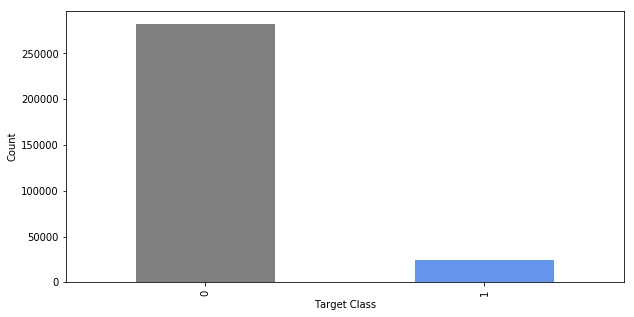

In [16]:
# Plot TARGET distribution
a_train['TARGET'].value_counts()
a_train['TARGET'].value_counts().plot(kind='bar', figsize=(10,5), color = ['grey', 'cornflowerblue'])
plt.xlabel('Target Class')
plt.ylabel('Count') 
plt.show()

TO DO:
* Visualisations / kde
* Find anomalies (programatically if possible)
* Feature Engineer some features
* Fit initial models with and without features
* Test a final model

### Visualising affect on Target variable using Proportion Target Positive plots or Kernal Density Estimation (KDE) plots

In order to help us understand the affect an independent variable is having on our target of default or not default, we should ideally visualise the data.  A histogram will be dependent on the underlying distribution of the independent variable, i.e. if there are lots of young people in the dataset, then the positive class may appear to be higher in this group simply because there are more of both classes. There are a couple of ways around this which can help us understand the data better.

1.  For categorical values, we can plot the proportion (%) of each category that has a positive class
2. For continuous variables, we can use a KDE plot. This plot estimates the histogram as a probability density function (pdf) which is essentially a smoothed histogram, where the area under the chart sums to a probability of 1. This is useful for us to see how the probability of a negative or positive target class changes with different ranges of the independent variable. 

Below is an example KDE plotted for Age using a function I have written, which enables you to pick you variable but also reverse the scale when required (say for Age which is in minus days)

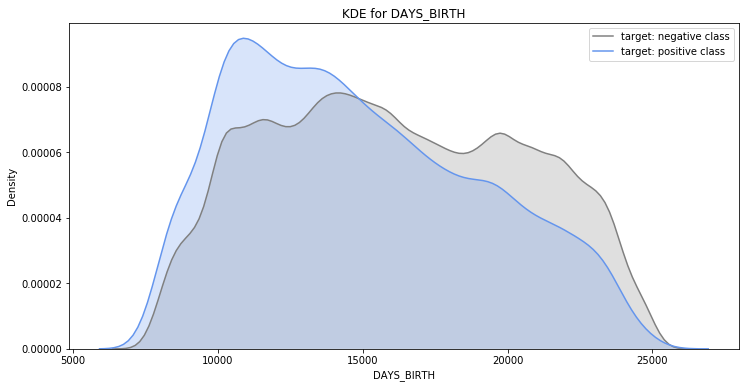

In [17]:
# Create function for plotting kde with scale reversing
def plot_kde(df, var, reverse_scale = False):
    
    plt.figure(figsize = (12, 6))
    
    if reverse_scale == True:
        r = -1
    else:
        r = 1
    
    # KDE plot of loans that were repaid on time
    sns.kdeplot(df.loc[df['TARGET'] == 0, var] * r, label = 'target: negative class', color = 'grey', shade = True)

    # KDE plot of loans which were not repaid on time
    sns.kdeplot(df.loc[df['TARGET'] == 1, var] * r, label = 'target: positive class', color = 'cornflowerblue', shade = True)

    # Labeling of plot
    plt.xlabel('{}'.format(var)); plt.ylabel('Density'); plt.title('KDE for {}'.format(var));
    plt.show()
    plt.close()

# plot age kde plot
plot_kde(a_train,'DAYS_BIRTH', True)

### Age

We can see straight away that age seems to play a big factor in defaulting on a loan. There is a very clear elevation to default in the younger age groups. This is interesting knowledge to have since in future we could use this kind of knowledge to optimise our model if we were removing features (we would not remove this one) and we could look to engineer further more detailed features using this knowledge.

### Iterative Graphing

Whilst not the prettiest visualisations, we can use python to quickly produce multiple iterations over many variables for this type of graph using the function we defined. 

We can use this to quickly observe many metrics, pull out immediate trends and spot any issues with our data **quickly**, which is the purpose of this kind of initial EDA and model building. 

In more detailed studies we could spend time producing more detailed visualisations if there is more to understand.

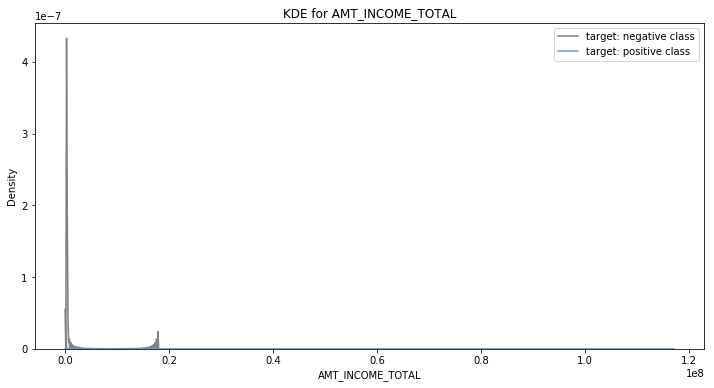

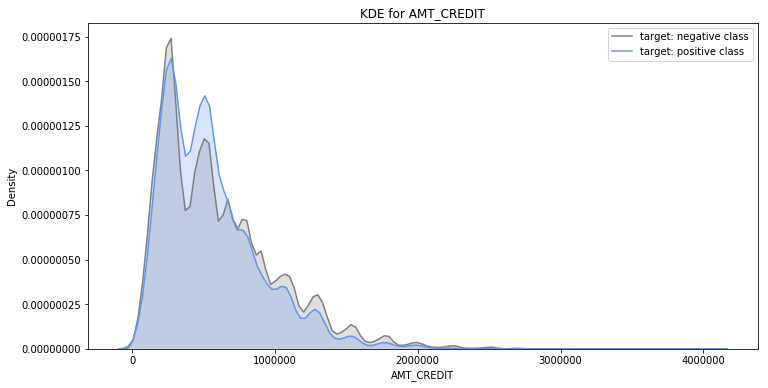

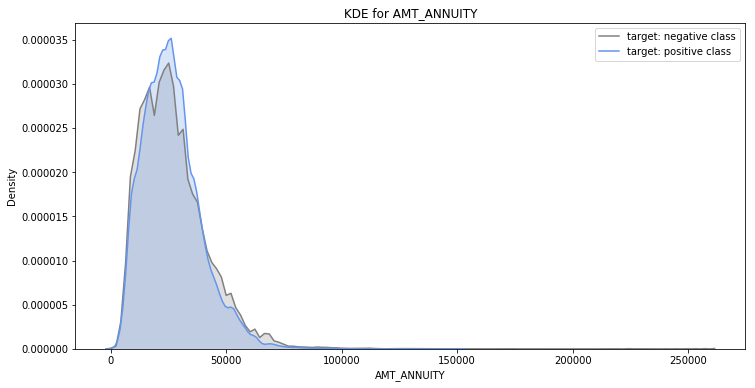

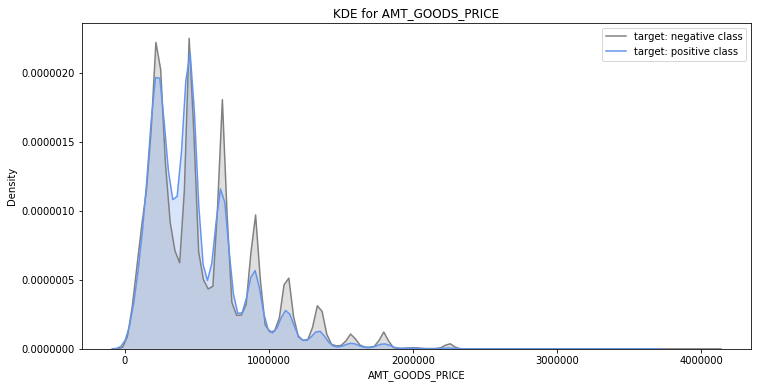

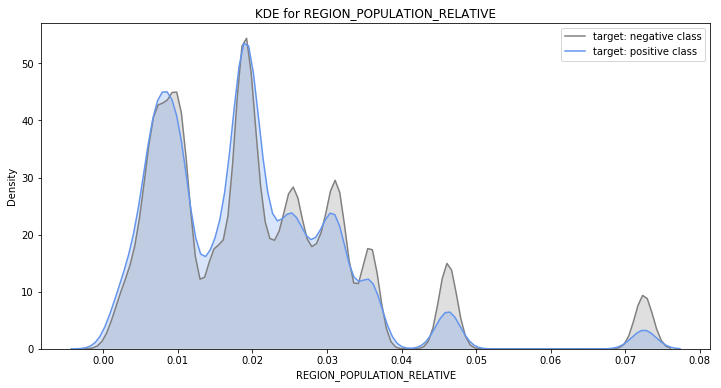

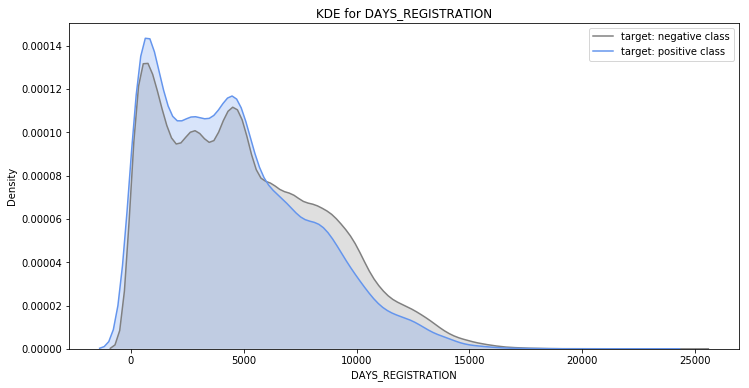

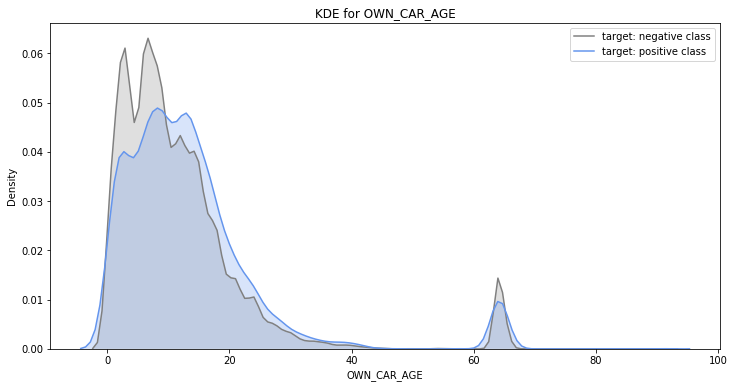

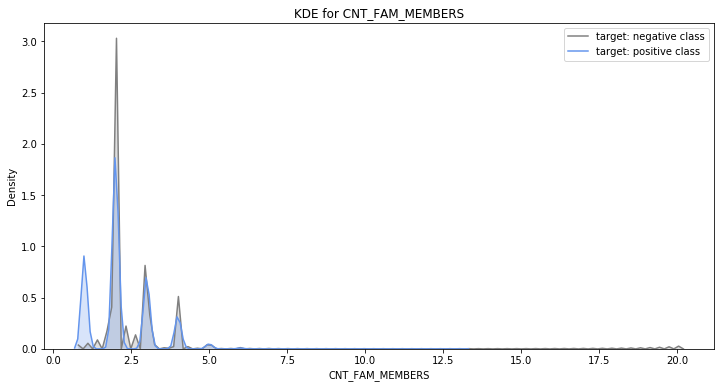

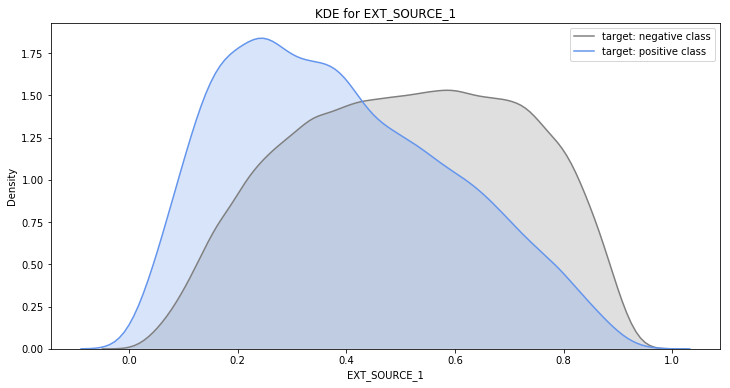

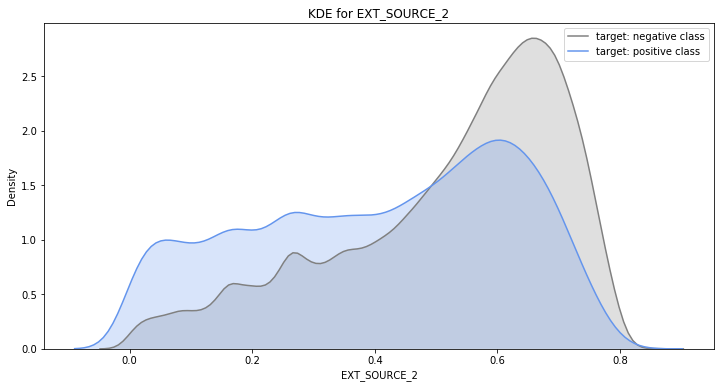

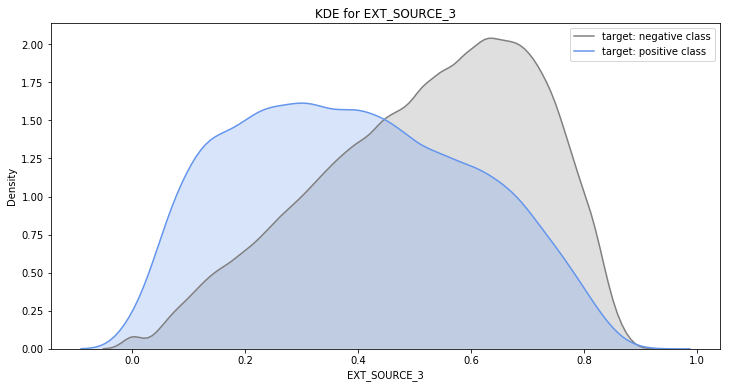

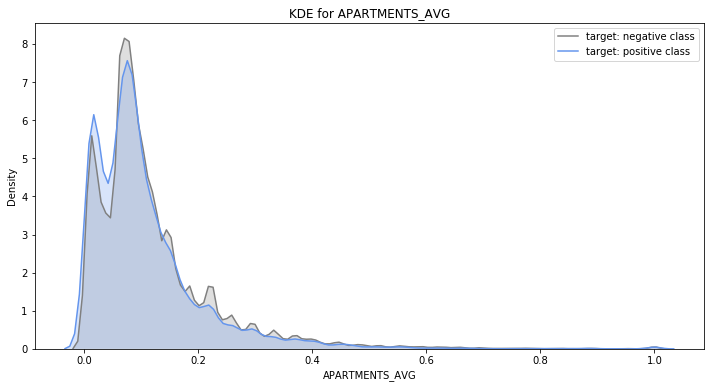

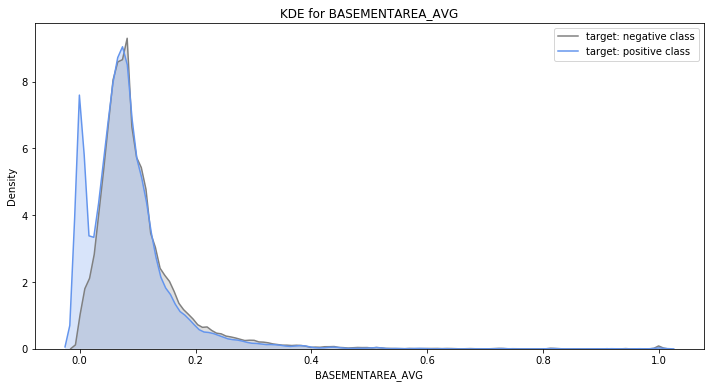

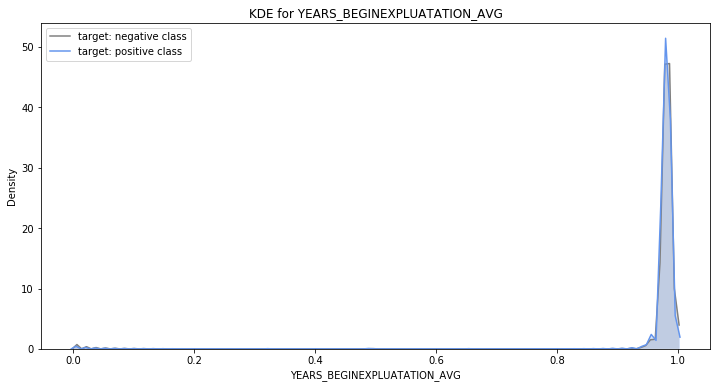

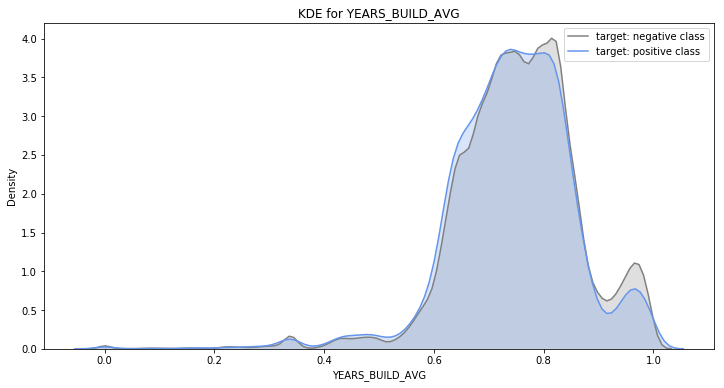

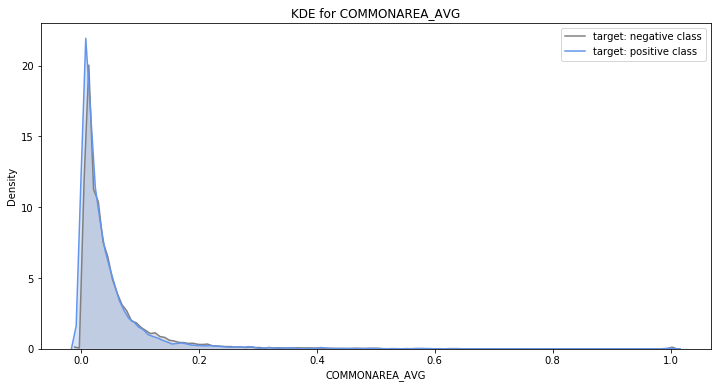

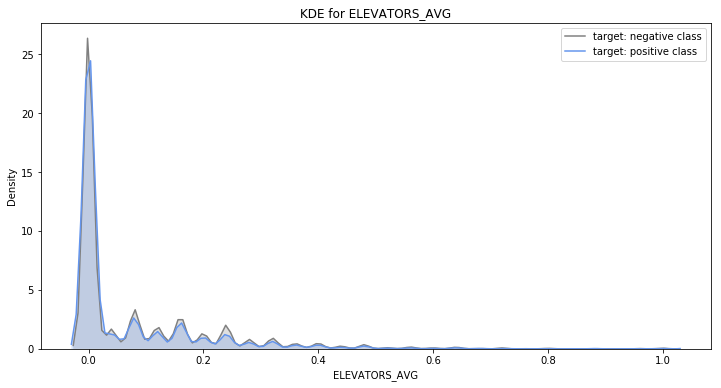

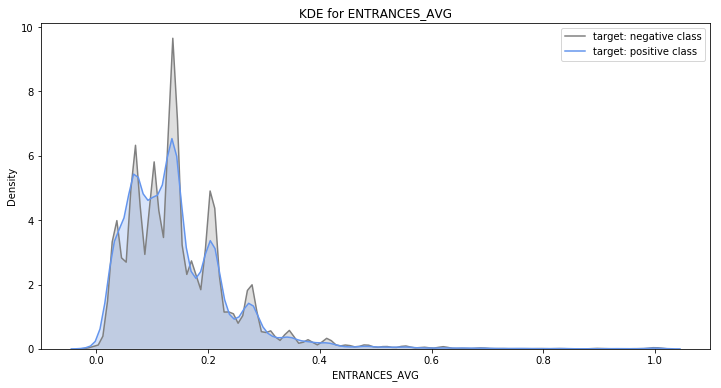

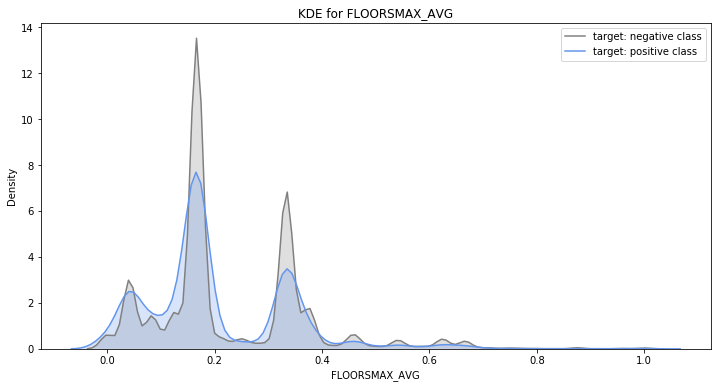

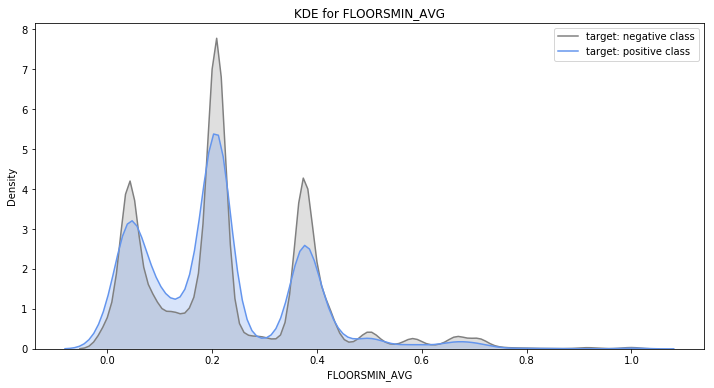

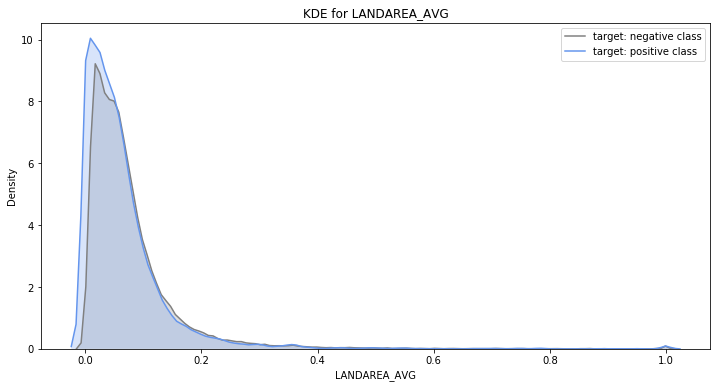

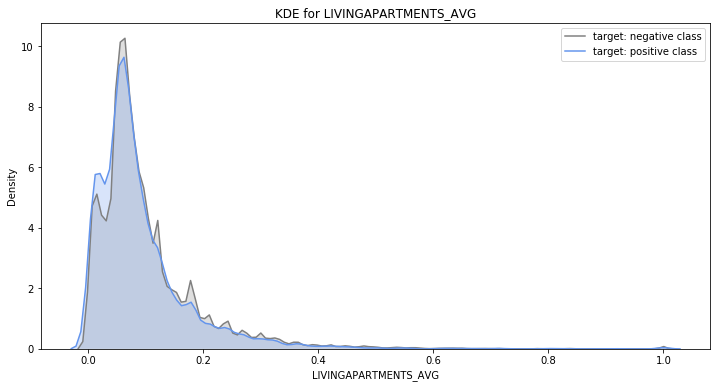

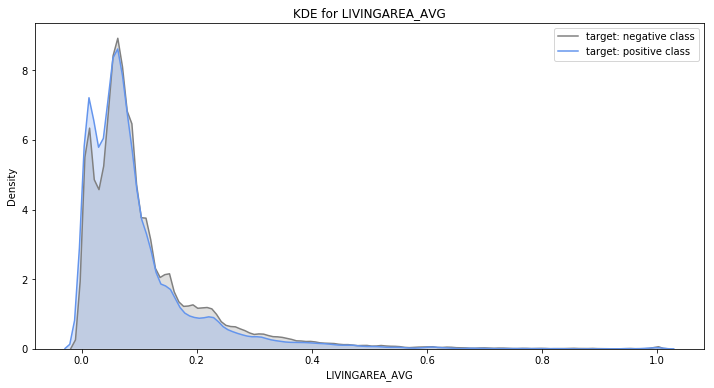

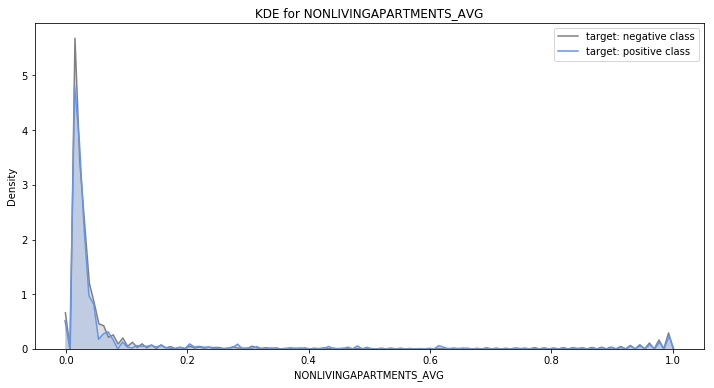

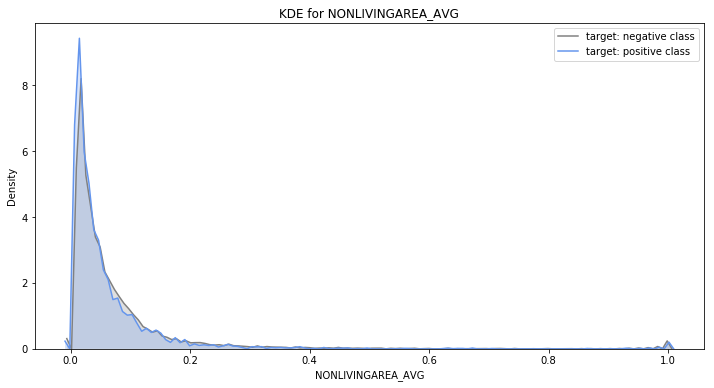

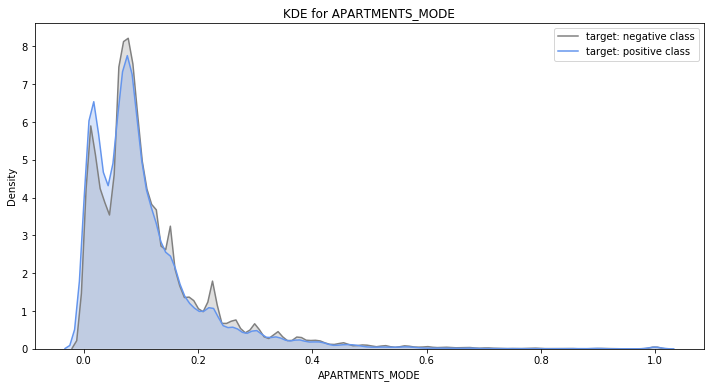

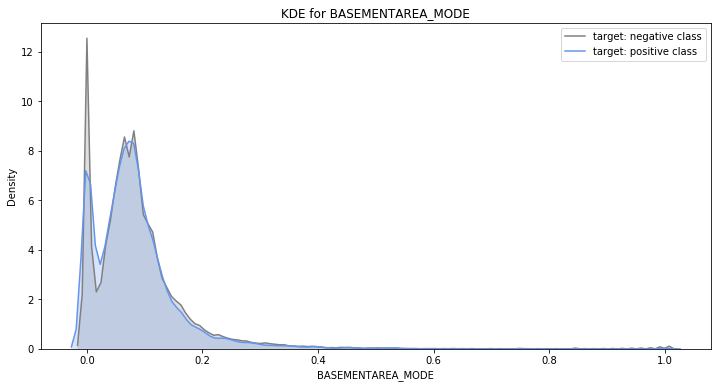

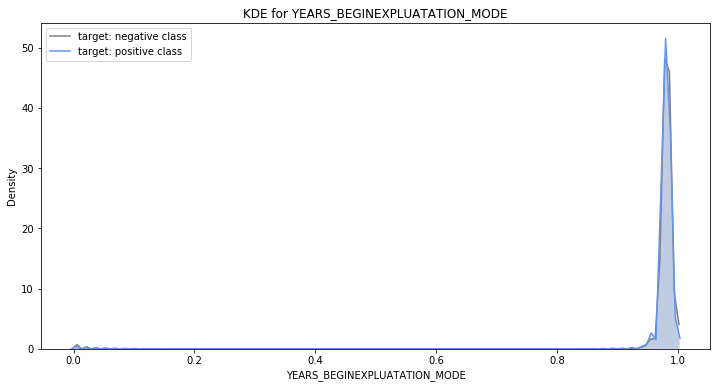

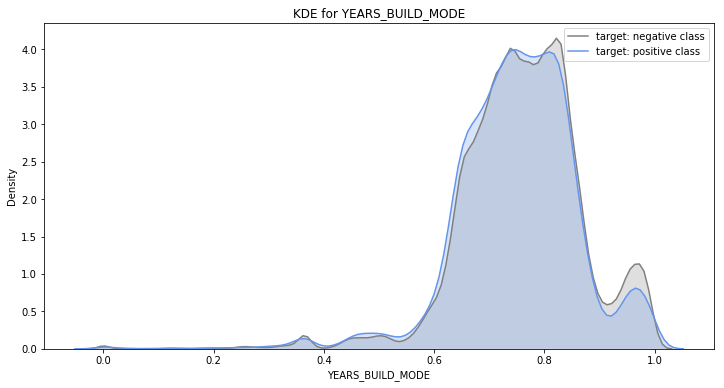

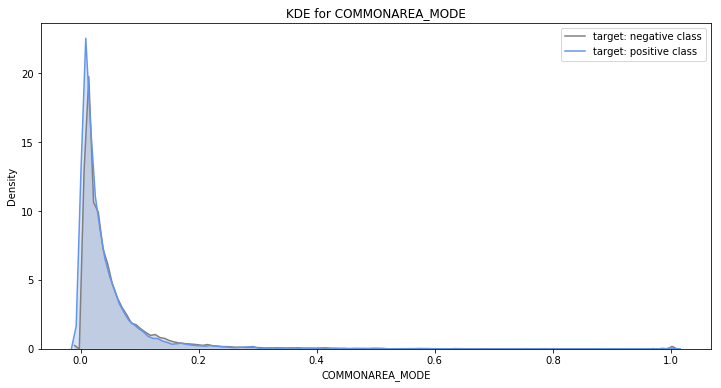

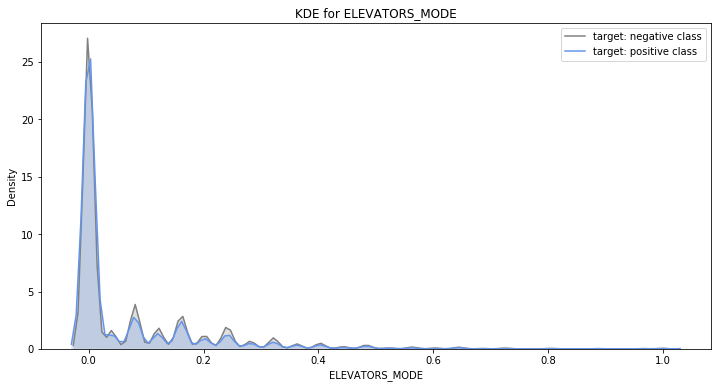

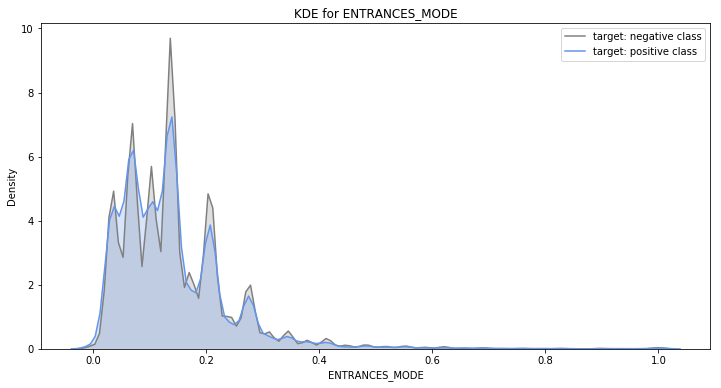

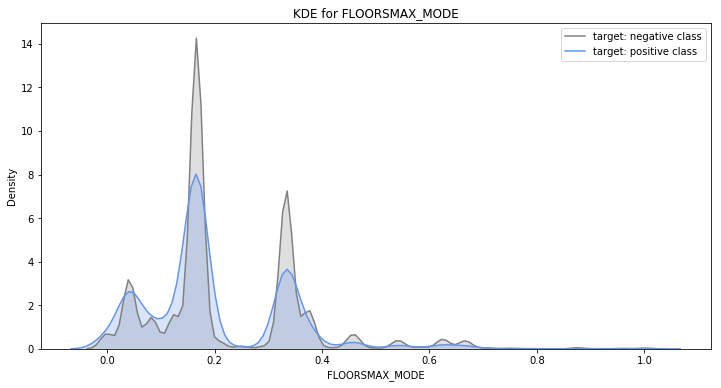

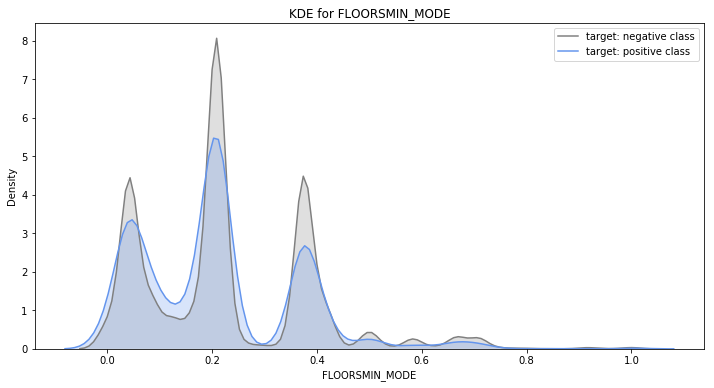

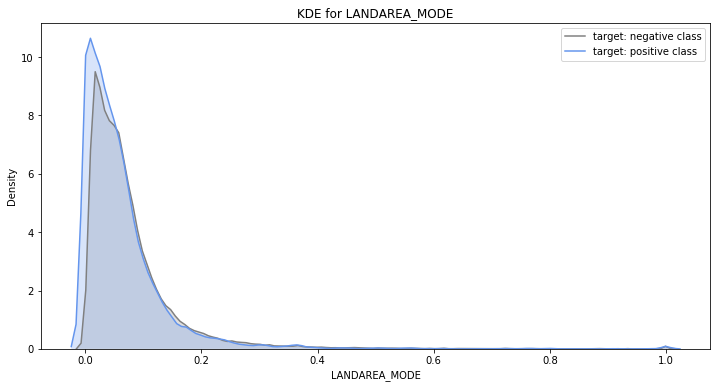

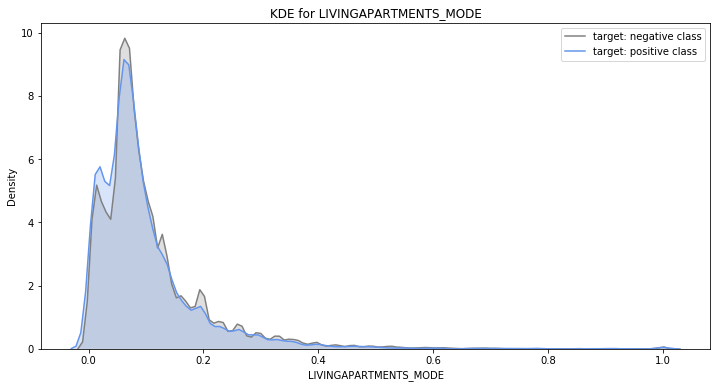

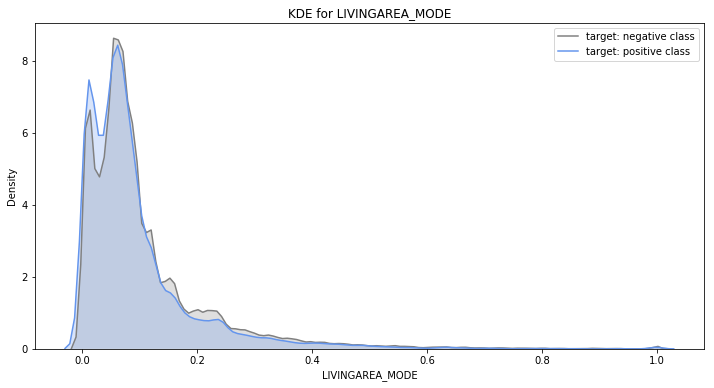

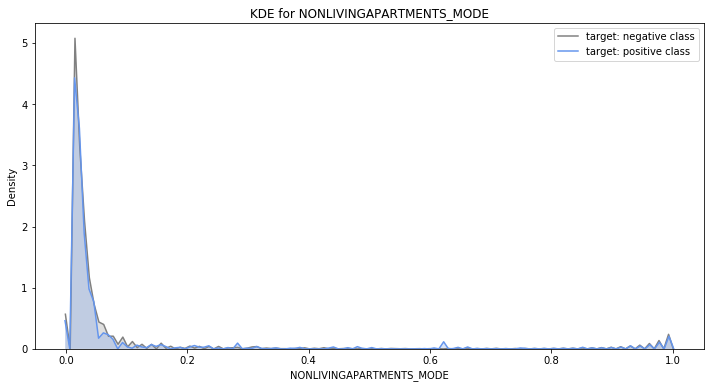

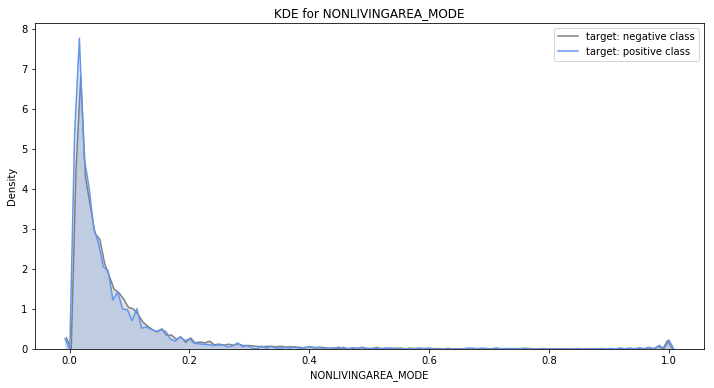

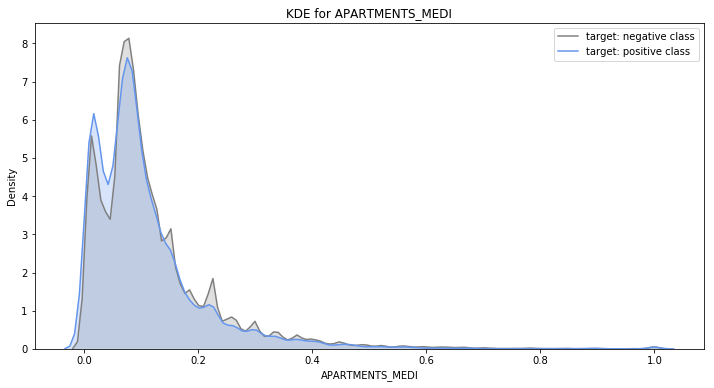

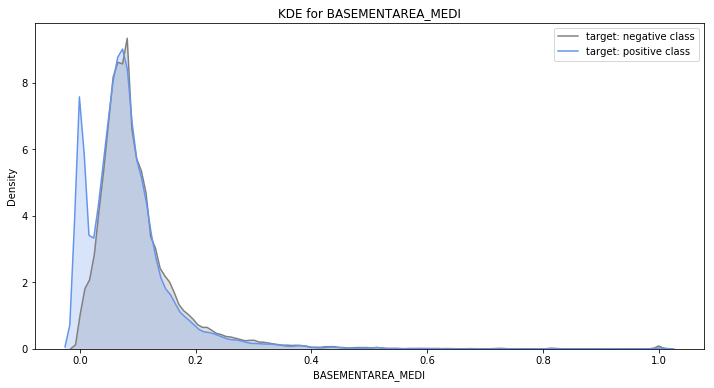

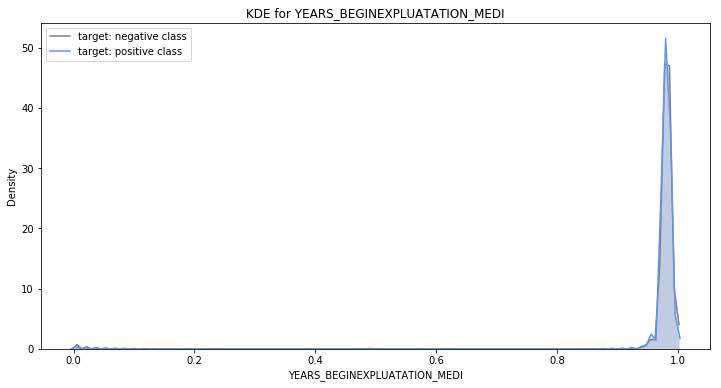

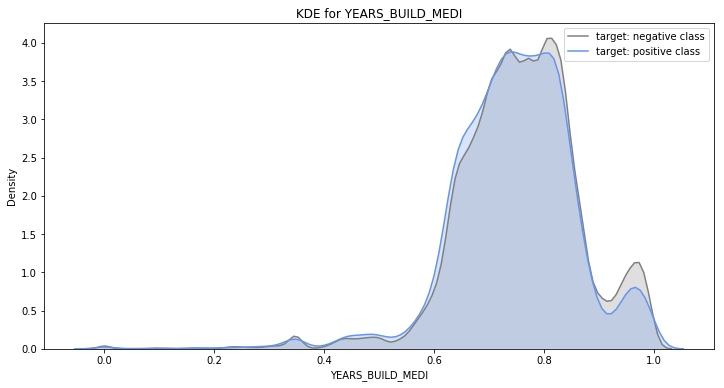

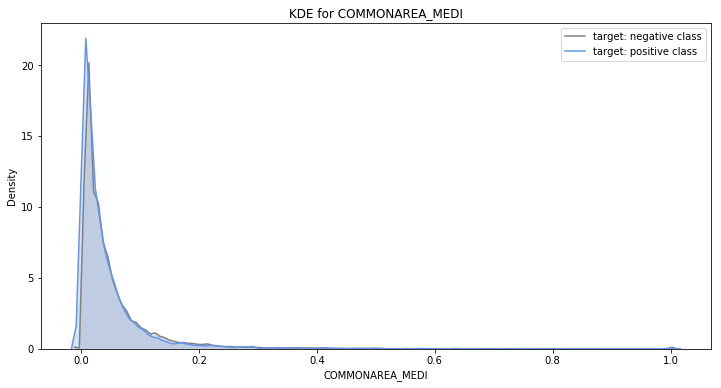

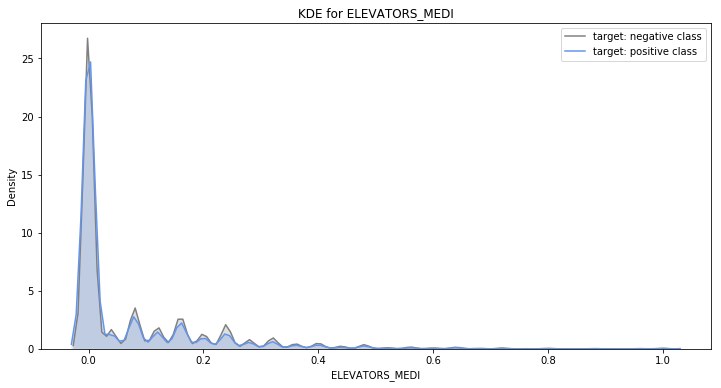

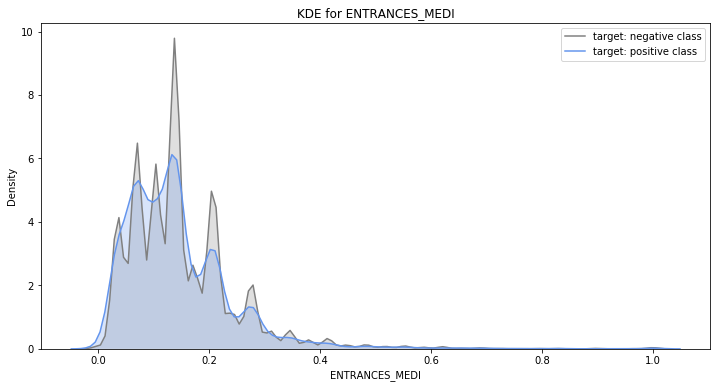

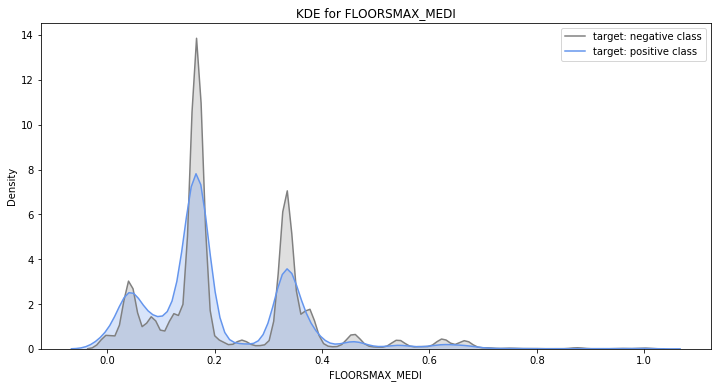

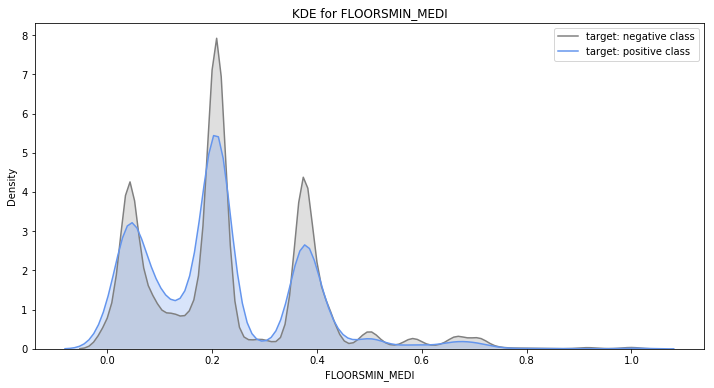

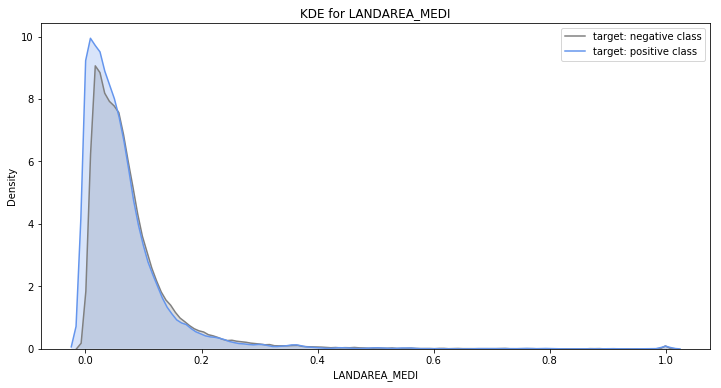

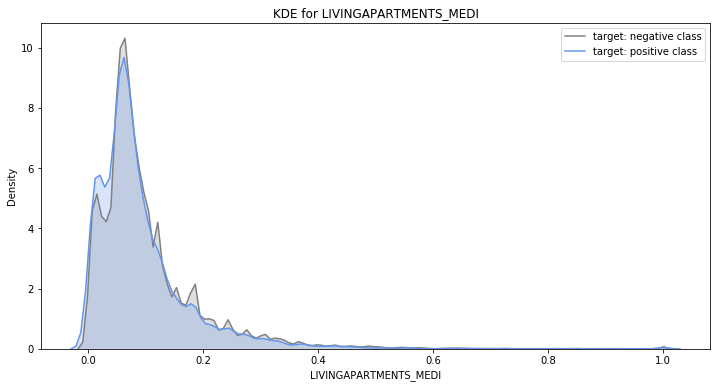

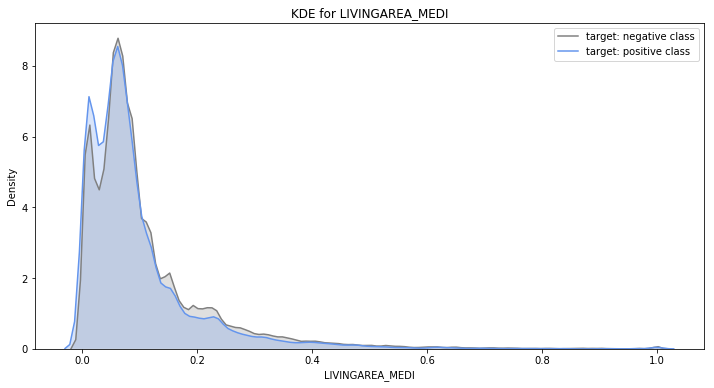

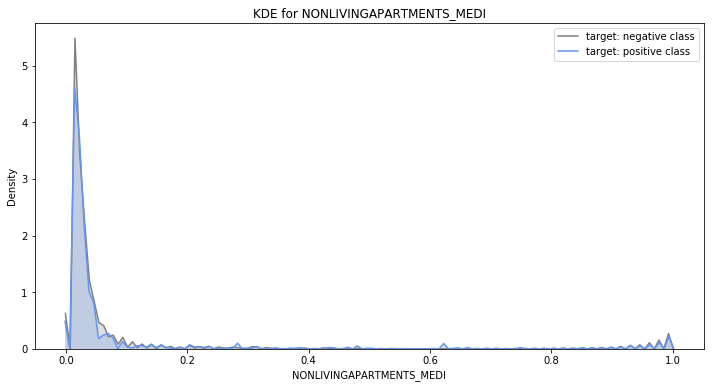

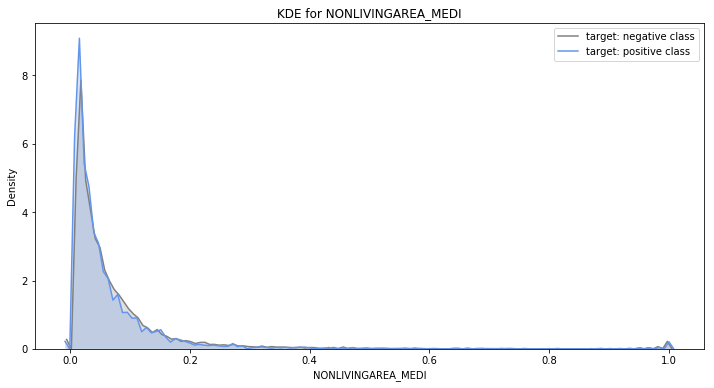

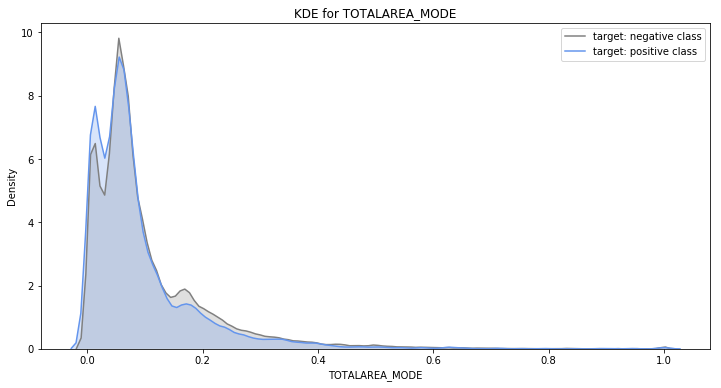

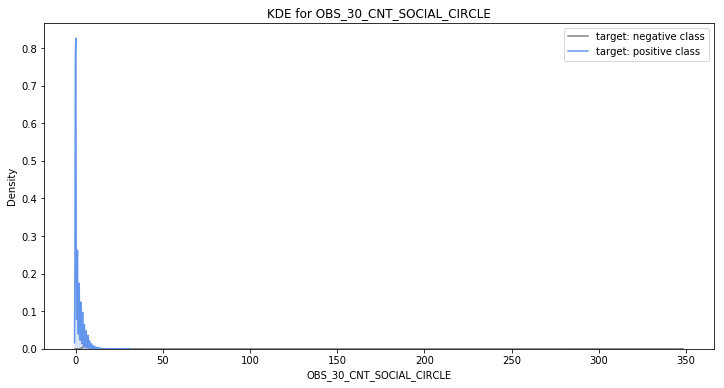

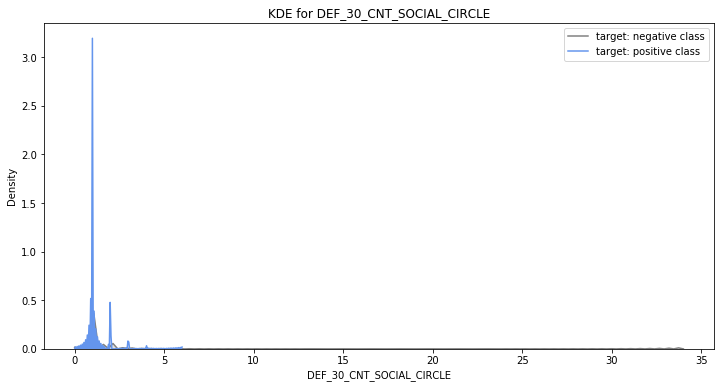

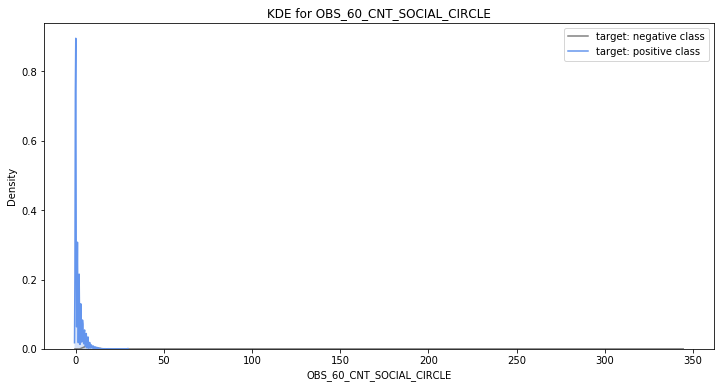

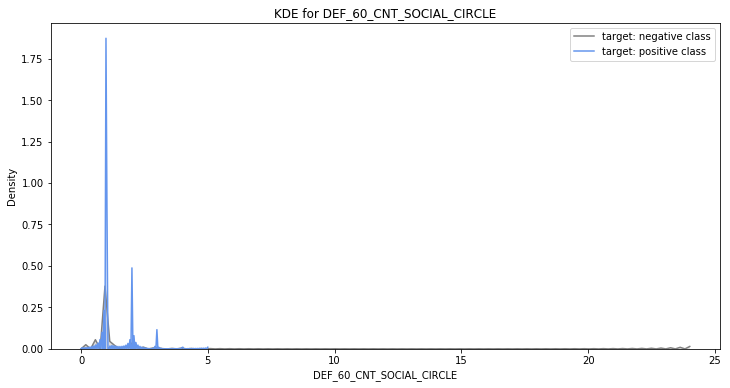

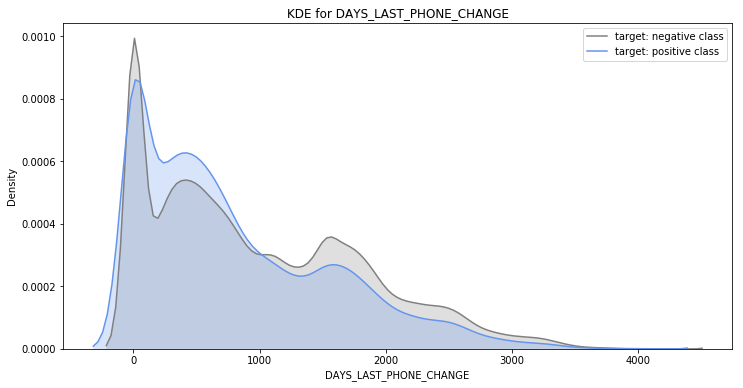

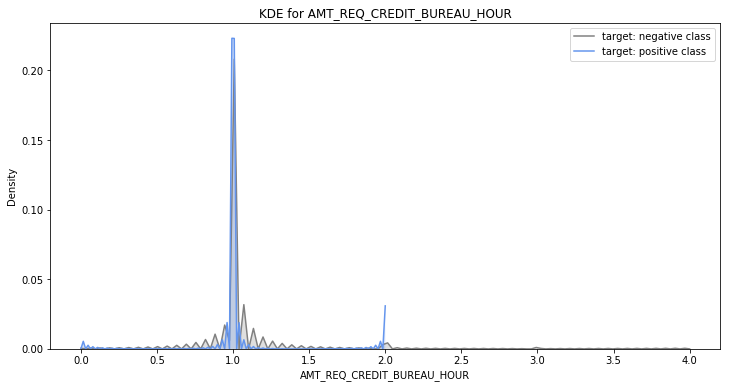

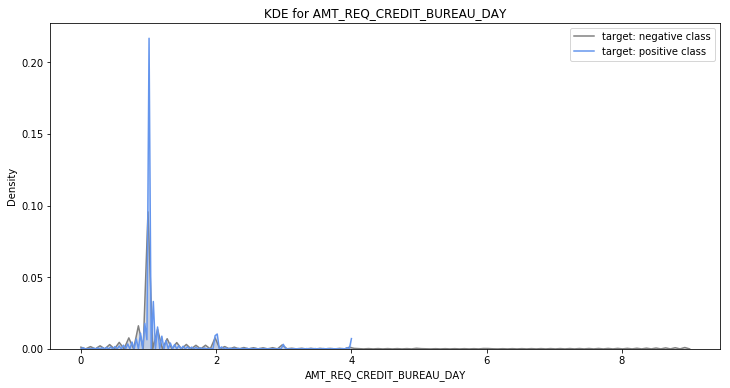

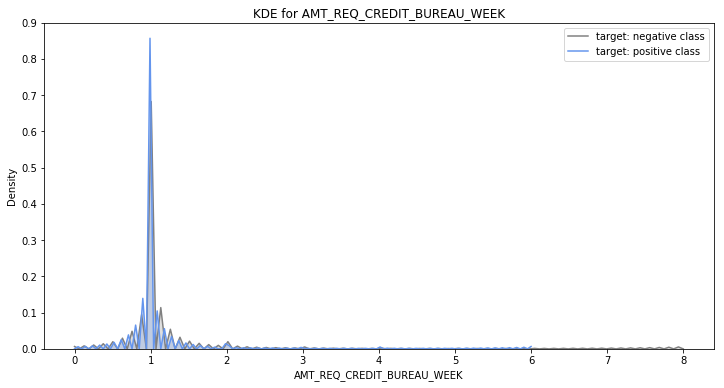

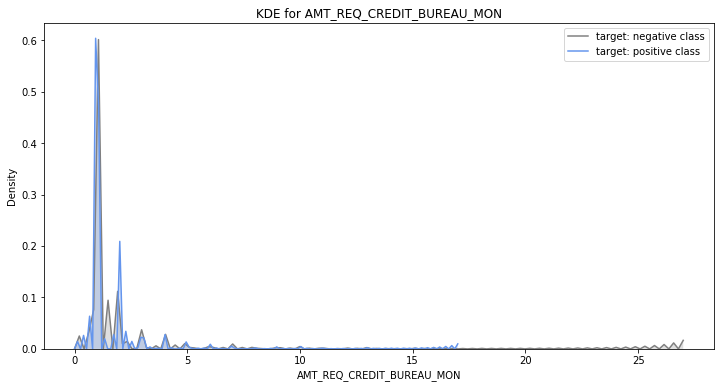

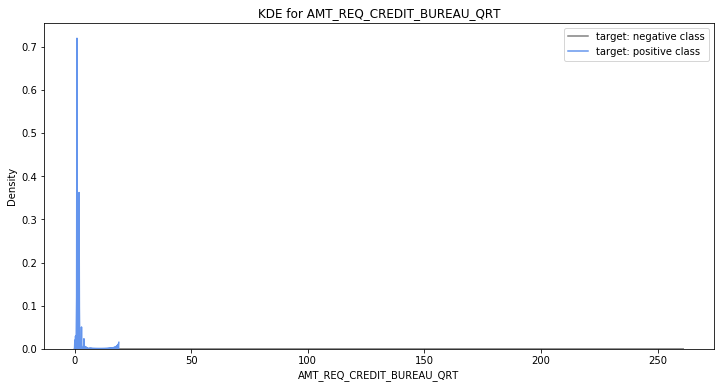

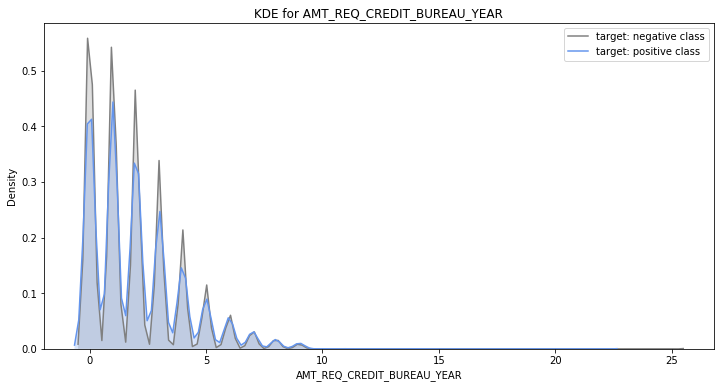

In [18]:
# iterate over float variables and plot KDE
for column in original_a_train.loc[:, (original_a_train.dtypes == np.float64)].columns.values:
    # do not plot target 
    if column != 'TARGET':
        # reverse axis if values are negative
        if (original_a_train[column].median() < 0):
            plot_kde(a_train,column, reverse_scale = True)
        else:
            plot_kde(a_train,column)

### Trends from Numeric Visualisations

#### Feature Outliers

One thing that is immediately obvious from these kde plots is that some of the variables appear to have huge outliers, and so the kde plot is highly skewed. This means we see a tall, sharp peak on one part of the axis followed by a thin layer on the bottom. It is hard to visualise data that is this skewed, and for these plot we need to investigate further these outliers and (if possible) determine whether they are legitimate or due to error. I will look at this in the next section.

#### Other intesting trends

* Days since last phone change shows that those who have changed their phones very recently and those who haven't changed their phone is years are more likely to default on a loan. 
* The EXT_SOURCE plots all appear to hold information for predicting default, as we see quite a strong separation in the distributions
* Many of the variables are hard to understand, and appear to be scaled aggregations (avgs, modes, medians) of more detailed metrics.

### Outliers

We established from the charts above that there are outliers in some of the numeric features above. In a more detailed study I would look to observe some of these in more detail, but for the purposes of this notebook and producing an intial baseline model I want to look at an example. In model optimisation, I could look at how these outliers may affect the model and process them in a way to ensure a model that is not skewed due to collection error.

I will look at total income amount as this is the first plot which displays outlier behaviour above.

In [19]:
def analyse_outliers(df, column):
    
    # Print Summary Statistics
    print('Summary Statistics:\n')
    print(df[column].describe())

    # find mean and std
    outlier_df = df[column]
    std = outlier_df.std()
    print('\nStandard Deviation: ', std)
    mean =  outlier_df.mean()
    print('Mean: ', mean)

    # how many std is the max
    max_outlier = int((outlier_df.max() - mean) / std)

    # separate outliers over 2 std from mean
    outliers_l = outlier_df[(outlier_df < mean - 2 * std)]
    outliers_h = outlier_df[(outlier_df > mean + 2 * std)]
    print('\nThere are {} low end outliers in the {} dataset'.format(len(outliers_l), column ))    
    print('There are {} high end outliers in the {} dataset'.format(len(outliers_h), column ))
    print('The max value is {} standard deviations from the mean'.format(max_outlier))
    
    return mean, std

income_mean, income_std = analyse_outliers(a_train, 'AMT_INCOME_TOTAL')   

Summary Statistics:

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

Standard Deviation:  237123.14627883647
Mean:  168797.9192969845

There are 0 low end outliers in the AMT_INCOME_TOTAL dataset
There are 1438 high end outliers in the AMT_INCOME_TOTAL dataset
The max value is 492 standard deviations from the mean


One thing that really stands out above is how much of an outlier the maximum value is at 492 standard deviations from the mean. 177M salary could potentially be accurate, and with more information about the data this may be possible to find out. Regardless, it is possible that this value will really skew a model fit to the data, and could potentially be removed, particularly if it is found to be an error.

This kind of analysis could be repeated for more of the features, and the written above function could be reused to enable this.

## Continued Exploratory Data Analysis
### Looking at trends in the Categorical Variables

As mentioned above, we can plot proportions of target being the positiive class against each categorical variable value to see which groups have higher default rates.

In [59]:
# define function for plotting categorical bar charts for remaining variables
def categorical_plot(df, variable):
    
    plt.figure(figsize = (12, 6))
    
    df_high = df[df['TARGET'] == 1].groupby(variable)['TARGET'].agg('count')
    df_var = df.groupby(variable)['TARGET'].agg('count')
    categorical = df_high.divide(df_var, fill_value = 0) * 100

    # Convert back to df
    df_categorical = categorical.to_frame().reset_index().sort_values('TARGET', ascending = True)

    # Create plot in Plotly for interactive visualisation (with some Starling colours)
    ax = df_categorical.plot(x = variable, y = 'TARGET', kind = 'kde', figsize=(6,4), color = 'red')
    ax.set_xlabel('Target: Positive %')
    ax.set_ylabel(variable)
    plt.title('% postive plot for {}'.format(variable.lower()));
    plt.show()
    plt.close()


<Figure size 864x432 with 0 Axes>

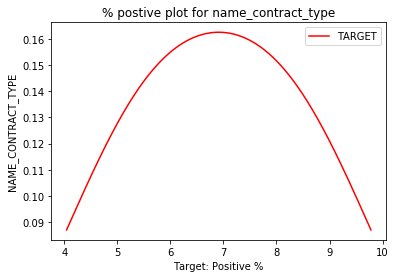

<Figure size 864x432 with 0 Axes>

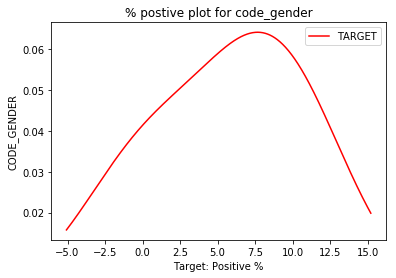

<Figure size 864x432 with 0 Axes>

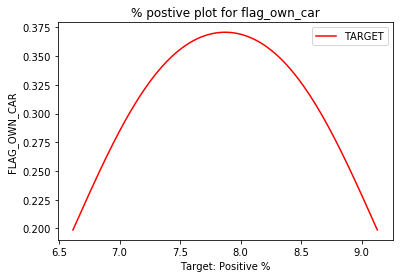

<Figure size 864x432 with 0 Axes>

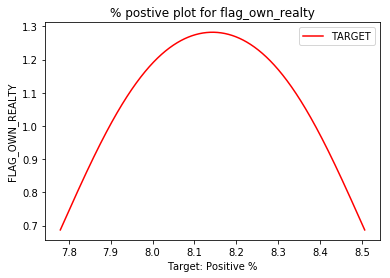

<Figure size 864x432 with 0 Axes>

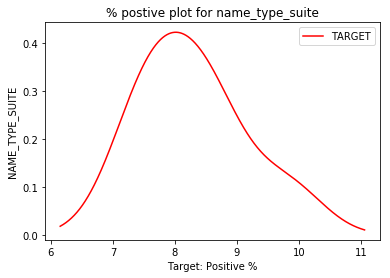

<Figure size 864x432 with 0 Axes>

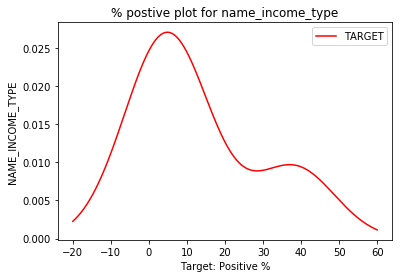

<Figure size 864x432 with 0 Axes>

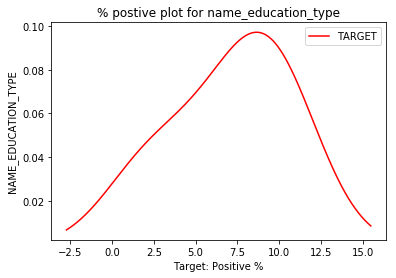

<Figure size 864x432 with 0 Axes>

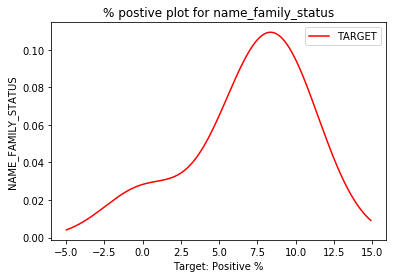

<Figure size 864x432 with 0 Axes>

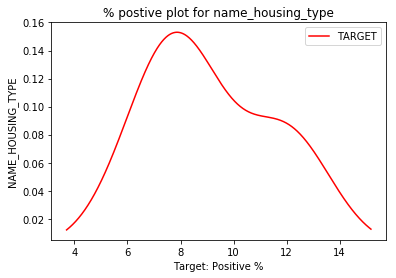

<Figure size 864x432 with 0 Axes>

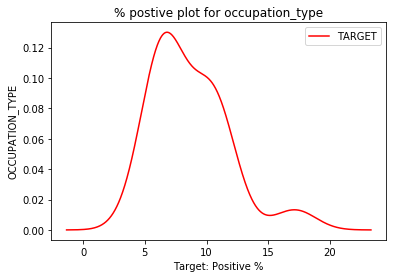

<Figure size 864x432 with 0 Axes>

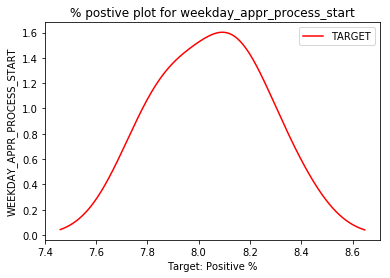

<Figure size 864x432 with 0 Axes>

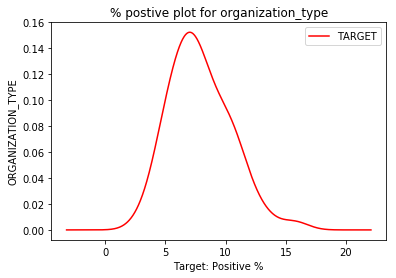

<Figure size 864x432 with 0 Axes>

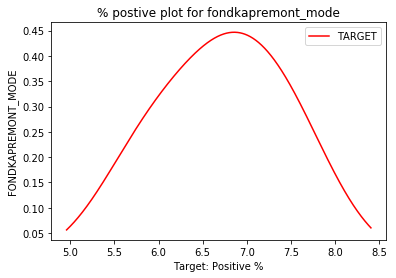

<Figure size 864x432 with 0 Axes>

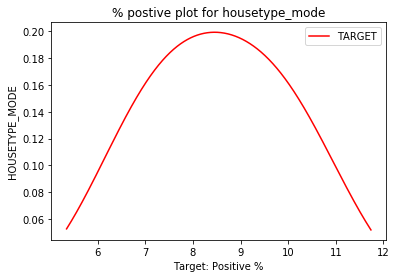

<Figure size 864x432 with 0 Axes>

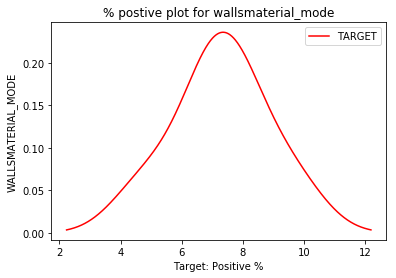

<Figure size 864x432 with 0 Axes>

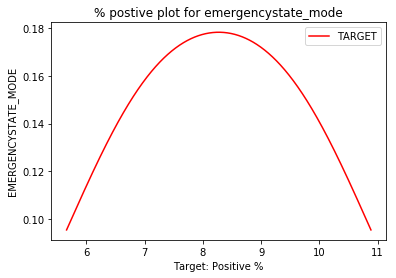

In [60]:
# iterate over np.object columns and plot
for column in original_a_train.loc[:, original_a_train.dtypes == np.object].columns.values:
    categorical_plot(original_a_train, column)

### Trends from Categorical Visualisations

* Income type, Education and occupation type appear to have quite a range when it comes to default rate. Which makes sense, as you would imagine that those will lower income jobs are more likely to be unable to repay a loan. 
* Day of application has some very minor variation, but you would hope that the day of the week someone applies on would be less linked to their likelihood of default. Although until obeserving the trend, we can never simply say that for sure.
* owning car or realty seems to have little affect, which is interesting as you would perhaps link ownership with more financial stability. But the trend shows that once again we should trust the data over our initial intuition.




### Correlations

To conclude our EDA, we can look at correlation coefficients between features and the target. This gives us a more quantitative measure for the relationships we have just explored visually. Below we will use the encoded variables for the correlations.

In [28]:
# Find correlations with the target(takes a while due to many features)
correlations = a_train.corr()['TARGET'].sort_values()

In [29]:
# print ordered list of correlations
print('Most Positive Correlations:\n')
print(correlations.sort_values(ascending = False).head(16))
print('\nMost Negative Correlations:\n')
print(correlations.head(15))

Most Positive Correlations:

TARGET                                               1.000000
DAYS_BIRTH                                           0.078239
REGION_RATING_CLIENT_W_CITY                          0.060893
REGION_RATING_CLIENT                                 0.058899
NAME_INCOME_TYPE_Working                             0.057481
DAYS_LAST_PHONE_CHANGE                               0.055218
CODE_GENDER_M                                        0.054713
DAYS_ID_PUBLISH                                      0.051457
REG_CITY_NOT_WORK_CITY                               0.050994
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
FLAG_EMP_PHONE                                       0.045982
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_DOCUMENT_3                                      0.044346
OCCUPATION_TYPE_Laborers                             0.043019
DAYS_REGISTRATION                                    0.041975
OWN_CAR_AGE                              

This agrees with some of the insight we were able to pull from the visualisations. Target correlates perfectly with itself as expected (almost acts as a good check for our code. Then we can see that age has a strong positive correlation, which is actually reversed because age is negative.

We also see that the EXT_SOURCE variables do seem to hold some information that will help us predict the target class. 

## Model Fitting

Before doing any feature engineering, lets run a cross validation against the training set. From this we can determine what the benchmark accuracy metrics are for a variety of models. This can help us narrow down which models are performing well on the data. 

Our training and test data has already been encoded suring the EDA steps. One final thing to do before passing the train data into a cross validation step would be to scale the numeric quantities, so that features with large values don't get assigned far greater weight in some machine learning algorithms.

In [30]:
# create X_train, y_train
X_train = a_train.drop('TARGET', axis = 1)
y_train = a_train['TARGET']
X_test = a_test

X_train = X_train.drop('SK_ID_CURR', axis = 1)
X_test = X_test.drop('SK_ID_CURR', axis = 1)

# Feature names
features = list(X_train.columns)

In [31]:
# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(X_train)

# Transform both training and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Repeat with the scaler
scaler.fit(X_train)
train = scaler.transform(X_train)
test = scaler.transform(X_test)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

C:\Users\Vijayalaskmi\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Training data shape:  (307511, 238)
Testing data shape:  (48744, 238)


In [32]:
# Using Cross Validation to find a good model
num_folds = 5
seed = 1
scoring = 'roc_auc'
models = []

# Typical Classifiers
models.append(('LR', LogisticRegression()))
# models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
# models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))

# iterate over models and print cross val scores
results = []
names = []
print('Please wait while models train..')
for name, model in models:
    
    # start timer
    start = time.time()
    
    # Cross Validation
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    
    # stop timing
    end = time.time()
    time_run = (end - start)/60
    output = "{}--> auroc: {}   (Training Time: {}mins)".format(name, cv_results.mean(), time_run)
    
    print(output)

Please wait while models train..
LR--> auroc: 0.6220890833513872   (Training Time: 0.7671114603678385mins)
DTC--> auroc: 0.5389869360031783   (Training Time: 3.0178051471710203mins)
RF--> auroc: 0.6295348860294575   (Training Time: 1.284961716334025mins)


We can see there is not much in it between LR and Random Forest both on the evaluation metric and training time. As we progress our solution we should aim to produce a more optimised model, and as such a more complex model such as Random Forest (which is an ensemble method) will gives us more flexibility when we start training hyperparameters. There are also fair more effective algorithms which I could explore, but they are slightly too complex to cover in this inital notebook, or take a very long time to train on a dataset this large.

So to create our baseline model I will use Random Forest in this instance. 

### Training Model and Test Predictions

In [33]:
# Train LR Model
RF = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
RF.fit(X_train,y_train)

# Extract feature importances
feature_importance_values = RF.feature_importances_
feature_importances = pd.DataFrame({'Feature': features, 'Importance': feature_importance_values})

# Make predictions on the test data
predictions = RF.predict_proba(test)[:, 1]

# Make a submission dataframe
submit = a_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline.csv', index = False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


#### Model Performance
We now have a baseline dataset for submission. The ROC score for the model upon submission was: **0.653**. 

0.5 is not better than random guessing, and 0.80 was a winning score in the competition. For a baseline model this is quite satisfying. However, this is the simple model which we can now aim to build on and improve by:

* Enriching the dataset with additional data (Adding Features)
* Create new features from existing data (Feature Engineering)
* Tuning Hyperparameters to improve the model performance
* Testing more cutting edge machine learning and deep learning models

#### Feature Importance

Below is a function I have created to plot feature importances. Looking at the plot we can immediately see that some of our exploratory data analysis had highlighted features which were important.

<Figure size 720x1152 with 0 Axes>

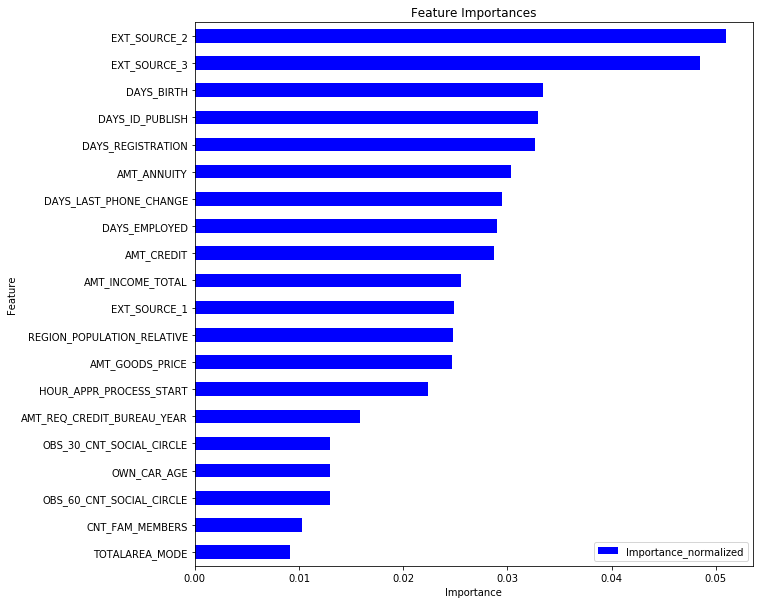

In [34]:
# Function to plot feature importance
def plot_feature_importance(df):

    # Normalize the feature importances to add up to one
    df['Importance_normalized'] = df['Importance'] / df['Importance'].sum()
    df = df.sort_values('Importance_normalized', ascending = True).tail(20)

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 16))

    ax = df.plot(x = 'Feature' , y = 'Importance_normalized', kind = 'barh', figsize=(10,10), color = 'blue')
    
    # Plot labeling
    plt.xlabel('Importance')
    plt.title('Feature Importances')
    plt.show()
    
    # return top 20 features
    return(df['Feature'])

top20 = plot_feature_importance(feature_importances)

## Feature Engineering

We can now try some quick feature engineering using the other datasets. 

In [39]:
# import bureau data
bureau = pd.read_csv('Input/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [40]:
# # create feature dataframe
bureau_agg = bureau['SK_ID_CURR'].unique()
bureau_agg = pd.DataFrame(bureau_agg, columns = ['SK_ID_CURR'])

In [41]:
# # previous loan count
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

bureau_agg = bureau_agg.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

In [42]:
# # active loan count
active_loan_counts = bureau[bureau['CREDIT_ACTIVE'] == 'Active'].groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'active_loan_counts'})
active_loan_counts.head()

# join new features
bureau_agg = bureau_agg.merge(active_loan_counts, on = 'SK_ID_CURR', how = 'left')

# fill na
bureau_agg = bureau_agg.fillna(0)

In [43]:
# # join additional features onto train and test
a_train_features = a_train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
a_test_features = a_test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
a_train_features = a_train_features.fillna(0)
a_test_features = a_test_features.fillna(0)

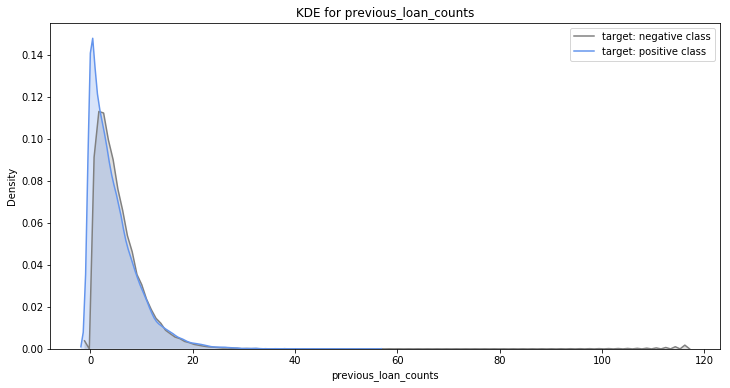

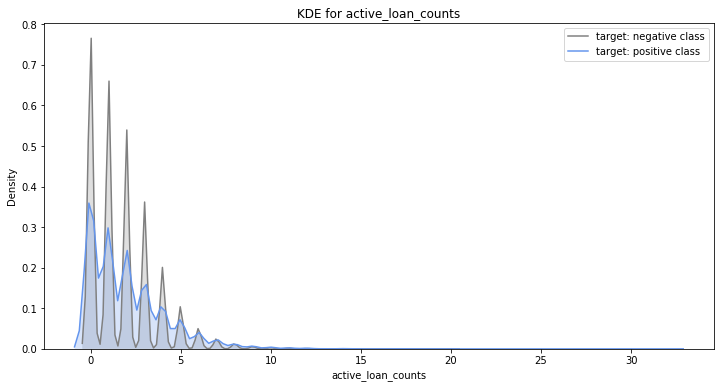

In [44]:
# # plot kde of new features
plot_kde(a_train_features, 'previous_loan_counts')
plot_kde(a_train_features, 'active_loan_counts')

In [45]:
print('Training data shape: ', a_train_features.shape)
print('Testing data shape: ', a_test_features.shape)

Training data shape:  (307511, 242)
Testing data shape:  (48744, 241)


### Re-run Random Forest Model

Now that we have an enriched train and test dataset, lets retrain the RF model under the same conditions.

C:\Users\Vijayalaskmi\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished


<Figure size 720x1152 with 0 Axes>

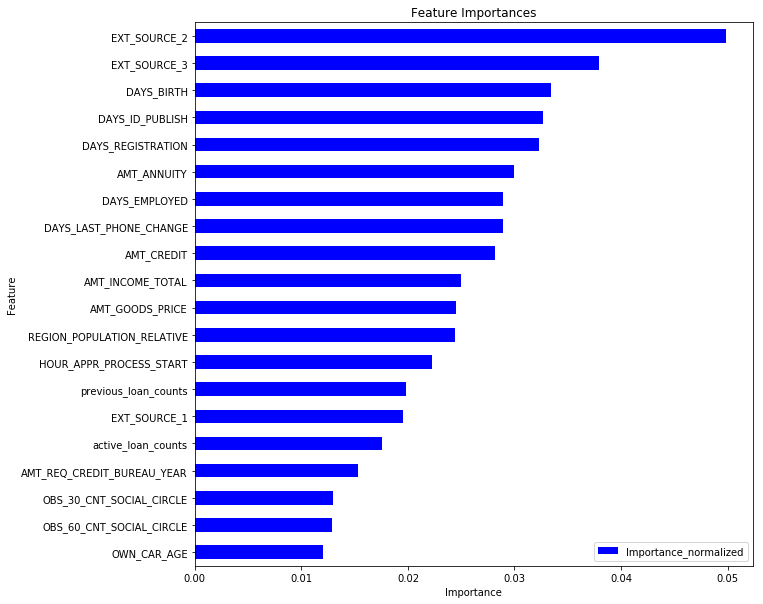

In [46]:
# create X_train, y_train
X_train = a_train_features.drop('TARGET', axis = 1)
y_train = a_train_features['TARGET']
X_test = a_test_features

X_train = X_train.drop('SK_ID_CURR', axis = 1)
X_test = X_test.drop('SK_ID_CURR', axis = 1)

# Feature names
features = list(X_train.columns)

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(X_train)

# Transform both training and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

# Repeat with the scaler
scaler.fit(X_train)
train = scaler.transform(X_train)
test = scaler.transform(X_test)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

# Train LR Model
RF = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
RF.fit(X_train,y_train)

# Extract feature importances
feature_importance_values = RF.feature_importances_
feature_importances = pd.DataFrame({'Feature': features, 'Importance': feature_importance_values})

# Make predictions on the test data
predictions = RF.predict_proba(test)[:, 1]

# Make a submission dataframe
submit = a_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_features.csv', index = False)

top20 = plot_feature_importance(feature_importances)

Despite now seeing that both of the new features are showing in the top list for features importance, this model actually underperforms the original baseline model by approx. 3 AUROC Score. 

That being said feature enrichment and model optimisation will be the path we need to follow to increase the ROC score. With future work, we should be able to increase that ROC score a fair bit more. 

## Using an LGBM Model

LGBM tends to do really well in competitions so I want to try it out here!

In [49]:
!pip install lightgbm
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [50]:
submission, fi, metrics = model(a_train_features, a_test_features)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (307511, 240)
Testing Data Shape:  (48744, 240)
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.548231	train's auc: 0.798671	valid's binary_logloss: 0.562701	valid's auc: 0.756595
[400]	train's binary_logloss: 0.519093	train's auc: 0.82782	valid's binary_logloss: 0.54504	valid's auc: 0.757078
Early stopping, best iteration is:
[352]	train's binary_logloss: 0.525282	train's auc: 0.821699	valid's binary_logloss: 0.548713	valid's auc: 0.75732
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.548657	train's auc: 0.79825	valid's binary_logloss: 0.563498	valid's auc: 0.758713
Early stopping, best iteration is:
[247]	train's binary_logloss: 0.540876	train's auc: 0.806071	valid's binary_logloss: 0.558906	valid's auc: 0.758974
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.549522	train's auc: 0.797715	valid's binary_logloss: 0.564539	v

In [56]:
def plot_feature_importances(df, num_bars = 15):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """

    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:num_bars]))), 
            df['importance_normalized'].head(num_bars), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:num_bars]))))
    ax.set_yticklabels(df['feature'].head(num_bars))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

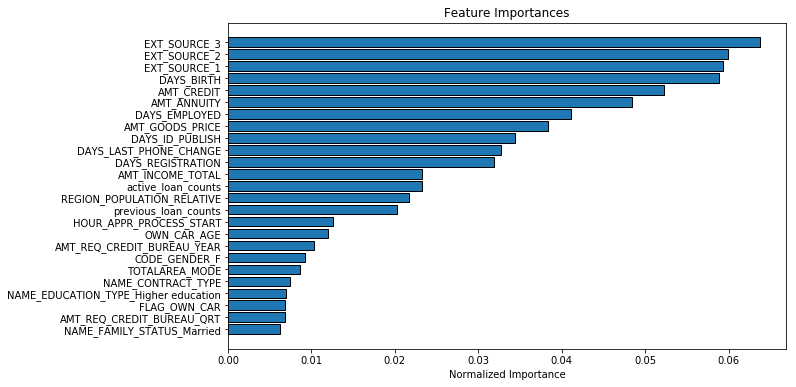

In [52]:
fi_sorted = plot_feature_importances(fi, 25)

In [54]:
submission.to_csv('Output/baseline_lgb_features.csv', index = False)